# Prediction pipeline for test set

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split

import src.feature_processor as fp
import src.model as model
import src.utils as utils

In [2]:
# Load data
train_path = '../data/train.xlsx'
test_path = '../data/test.xlsx'

train_data_raw, test_data_raw = pd.read_excel(train_path), pd.read_excel(test_path)

In [ ]:
# Fit and transform training data
# Final run, we feed entire train set to fit the model

feature_processor = fp.FeatureProcessor()

train_processed = feature_processor.fit_transform(train_data_raw)
test_processed = feature_processor.transform(test_data_raw)

nan_counts_train = train_processed.isna().sum()
nan_counts_test = test_processed.isna().sum()
print(f"Total NaN train values: {nan_counts_train.sum()}")
print(f"Total NaN test values: {nan_counts_test.sum()}")

Total NaN train values: 0
Total NaN test values: 0


In [7]:
# Prepare data for model
X_train = train_processed.drop(['quote_id', 'competitor_lowest_price'], axis=1)
y_train = train_processed['competitor_lowest_price']

X_test = test_processed.drop(['quote_id'], axis=1)
quote_ids = test_processed['quote_id']

In [9]:
pricing_model = model.PricingModel()
pricing_model.train_base_models(X_train, y_train, X_train, y_train)

[0]	train-quantile:4.93578	val-quantile:4.93578


/Users/paarruti/Documents/auto-insurance/venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:46:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	train-quantile:4.28586	val-quantile:4.28586
[200]	train-quantile:4.20222	val-quantile:4.20222
[299]	train-quantile:4.16793	val-quantile:4.16793
[0]	train-quantile:9.37116	val-quantile:9.37116


/Users/paarruti/Documents/auto-insurance/venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:46:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	train-quantile:7.93288	val-quantile:7.93288
[200]	train-quantile:7.77439	val-quantile:7.77439
[299]	train-quantile:7.70471	val-quantile:7.70471
[0]	train-quantile:13.44998	val-quantile:13.44998


/Users/paarruti/Documents/auto-insurance/venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:46:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	train-quantile:11.17299	val-quantile:11.17299
[200]	train-quantile:10.94762	val-quantile:10.94762
[299]	train-quantile:10.83195	val-quantile:10.83195
[0]	train-quantile:17.24370	val-quantile:17.24370


/Users/paarruti/Documents/auto-insurance/venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:47:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	train-quantile:14.05337	val-quantile:14.05337
[200]	train-quantile:13.74997	val-quantile:13.74997
[299]	train-quantile:13.60583	val-quantile:13.60583
[0]	train-quantile:20.73932	val-quantile:20.73932


/Users/paarruti/Documents/auto-insurance/venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:47:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	train-quantile:16.63402	val-quantile:16.63402
[200]	train-quantile:16.24282	val-quantile:16.24282
[299]	train-quantile:16.06412	val-quantile:16.06412
[0]	train-quantile:23.92243	val-quantile:23.92243


/Users/paarruti/Documents/auto-insurance/venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:47:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	train-quantile:18.86597	val-quantile:18.86597
[200]	train-quantile:18.42884	val-quantile:18.42884
[299]	train-quantile:18.22267	val-quantile:18.22267
[0]	train-quantile:26.75175	val-quantile:26.75175


/Users/paarruti/Documents/auto-insurance/venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:47:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	train-quantile:20.79597	val-quantile:20.79597
[200]	train-quantile:20.29141	val-quantile:20.29141
[299]	train-quantile:20.05881	val-quantile:20.05881
[0]	train-quantile:29.20549	val-quantile:29.20549


/Users/paarruti/Documents/auto-insurance/venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:47:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	train-quantile:22.39023	val-quantile:22.39023
[200]	train-quantile:21.84084	val-quantile:21.84084
[299]	train-quantile:21.58991	val-quantile:21.58991
[0]	train-quantile:31.25364	val-quantile:31.25364


/Users/paarruti/Documents/auto-insurance/venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:47:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	train-quantile:23.65674	val-quantile:23.65674
[200]	train-quantile:23.08376	val-quantile:23.08376
[299]	train-quantile:22.81038	val-quantile:22.81038
[0]	train-quantile:32.85107	val-quantile:32.85107


/Users/paarruti/Documents/auto-insurance/venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:47:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	train-quantile:24.61482	val-quantile:24.61482
[200]	train-quantile:23.98985	val-quantile:23.98985
[299]	train-quantile:23.71496	val-quantile:23.71496
[0]	train-quantile:33.93632	val-quantile:33.93632


/Users/paarruti/Documents/auto-insurance/venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:47:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	train-quantile:25.15332	val-quantile:25.15332
[200]	train-quantile:24.49514	val-quantile:24.49514
[299]	train-quantile:24.19947	val-quantile:24.19947
[0]	train-quantile:34.44374	val-quantile:34.44374


/Users/paarruti/Documents/auto-insurance/venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:47:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	train-quantile:25.32288	val-quantile:25.32288
[200]	train-quantile:24.61244	val-quantile:24.61244
[299]	train-quantile:24.29541	val-quantile:24.29541
[0]	train-quantile:34.27888	val-quantile:34.27888


/Users/paarruti/Documents/auto-insurance/venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:47:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	train-quantile:24.99895	val-quantile:24.99895
[200]	train-quantile:24.29924	val-quantile:24.29924
[299]	train-quantile:23.98422	val-quantile:23.98422
[0]	train-quantile:33.35335	val-quantile:33.35335


/Users/paarruti/Documents/auto-insurance/venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:47:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	train-quantile:24.21592	val-quantile:24.21592
[200]	train-quantile:23.49936	val-quantile:23.49936
[299]	train-quantile:23.17430	val-quantile:23.17430
[0]	train-quantile:31.53504	val-quantile:31.53504


/Users/paarruti/Documents/auto-insurance/venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:47:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	train-quantile:22.90558	val-quantile:22.90558
[200]	train-quantile:22.16931	val-quantile:22.16931
[299]	train-quantile:21.87693	val-quantile:21.87693
[0]	train-quantile:28.65483	val-quantile:28.65483


/Users/paarruti/Documents/auto-insurance/venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:47:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	train-quantile:20.90629	val-quantile:20.90629
[200]	train-quantile:20.19566	val-quantile:20.19566
[299]	train-quantile:19.91855	val-quantile:19.91855
[0]	train-quantile:24.47979	val-quantile:24.47979


/Users/paarruti/Documents/auto-insurance/venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:47:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	train-quantile:18.08711	val-quantile:18.08711
[200]	train-quantile:17.48066	val-quantile:17.48066
[299]	train-quantile:17.21494	val-quantile:17.21494
[0]	train-quantile:18.70658	val-quantile:18.70658


/Users/paarruti/Documents/auto-insurance/venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:47:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	train-quantile:14.22890	val-quantile:14.22890
[200]	train-quantile:13.75774	val-quantile:13.75774
[299]	train-quantile:13.56908	val-quantile:13.56908
[0]	train-quantile:10.78647	val-quantile:10.78647


/Users/paarruti/Documents/auto-insurance/venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:47:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	train-quantile:8.81317	val-quantile:8.81317
[200]	train-quantile:8.56639	val-quantile:8.56639
[299]	train-quantile:8.45083	val-quantile:8.45083


In [10]:
pricing_model.optimize_pricing_strategy(X_train, y_train)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     20 |             - |             -
     2 |      200 |     29 |  0.0135722893 |             f
     3 |      300 |     41 |  0.0086755350 |         ideal
     4 |      400 |     57 |  0.0075331822 |             f
     5 |      500 |     74 |  0.0049439068 |             f
     6 |      600 |     95 |  0.0033046373 |             f
     7 |      700 |    100 |  0.0035287185 |             f
     8 |      800 |    100 |  0.0029328985 |             f
     9 |      900 |    100 |  0.0026035364 |             f
    10 |     1000 |    100 |  0.0022950591 |             f
    11 |     1100 |    100 |  0.0038878287 |             f
    12 |     1200 |    100 |  0.0012620237 |             f
    13 |     1300 |    100 |  0.0024751265 |             f
    14 |     1400 |    100 |  0.0031154109 |             f
    15 |     1500 |    100 |  0.0016091461 |             f
    16 |     1600 |    100 |  0.0033270471 |            

In [37]:
params, market_share, avg_loss = pricing_model.select_optimized_pricing_strategy(market_share_threshold=0.31)
print(f"Market share: {market_share}, Avg loss: {avg_loss}")
for var_name, var_value in zip(model.PricingOptimizationProblem.VAR_NAMES, params):
    print(f"{var_name}: {var_value}")

Market share: 0.3153160337485446, Avg loss: 43.48627896863117
pred_quantile: 0.13447653713853122
upper_quantile: 0.7532799090014562
lower_quantile: 0.15953994083534181
spread_switch: -0.482243561916456


In [29]:
y_test = pricing_model.predict(X_test)
y_test[y_test > 100000] = np.nan
y_test_df = pd.DataFrame({'quote_id': quote_ids, 'proposed_price': y_test})

# Sanity checks on test set

In [30]:
y_train_opti = pricing_model.predict(X_train)
y_train_opti[y_train_opti > 100000] = np.nan
y_train_opti_df = pd.DataFrame({'quote_id': train_processed['quote_id'], 'proposed_price': y_train_opti})

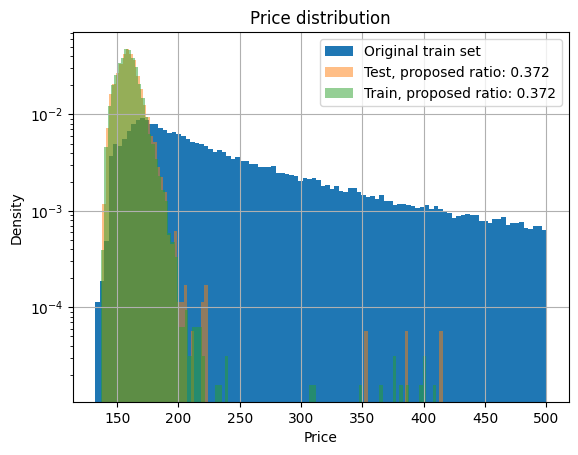

In [36]:
y_test_proposed = y_test_df[y_test_df['proposed_price'].notna()]
y_test_not_proposed = y_test_df[y_test_df['proposed_price'].isna()]
y_train_proposed = y_train_opti_df[y_train_opti_df['proposed_price'].notna()]
y_train_not_proposed = y_train_opti_df[y_train_opti_df['proposed_price'].isna()]

ratio_proposed_test = len(y_test_proposed)/len(y_test_df)
ratio_proposed_train = len(y_train_proposed)/len(y_train_opti_df)

fig, ax = plt.subplots()
y_train.hist(bins=100, ax=ax, label="Original train set", density=True)
y_test_proposed.hist(bins=100, ax=ax, density=True, label=f"Test, proposed ratio: {ratio_proposed_test:.3f}", alpha=0.5)
y_train_proposed.hist(bins=100, ax=ax, density=True, label=f"Train, proposed ratio: {ratio_proposed_train:.3f}", alpha=0.5)
ax.legend()
ax.set_xlabel("Price")
ax.set_ylabel("Density")
ax.set_title("Price distribution")
ax.set_yscale('log')
plt.show()


In [32]:
y_test_df.to_csv('../data/test_evaluation.csv', index=False)